In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
 

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_raw = pd.read_csv(r"D:\Shubham\Python ML\customer_churn_dataset\customer_churn_dataset.csv")
df_raw.head()

,customer_id,tenure,monthly_charges,total_charges,contract,payment_method,internet_service,tech_support,online_security,support_calls,churn
0,1,52,54.20,2818.40,Month-to-month,Credit,DSL,No,Yes,1,No
1,2,15,35.28,529.20,Month-to-month,Debit,DSL,No,No,2,No
2,3,72,78.24,5633.28,Month-to-month,Debit,DSL,No,No,0,No
3,4,61,80.24,4894.64,One year,Cash,Fiber,Yes,Yes,0,No
4,5,21,39.38,826.98,Month-to-month,UPI,Fiber,No,No,4,Yes


In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       20000 non-null  int64  
 1   tenure            20000 non-null  int64  
 2   monthly_charges   20000 non-null  float64
 3   total_charges     20000 non-null  float64
 4   contract          20000 non-null  object 
 5   payment_method    20000 non-null  object 
 6   internet_service  17987 non-null  object 
 7   tech_support      20000 non-null  object 
 8   online_security   20000 non-null  object 
 9   support_calls     20000 non-null  int64  
 10  churn             20000 non-null  object 
dtypes: float64(2), int64(3), object(6)
memory usage: 1.7+ MB


In [4]:
df_raw['internet_service'].unique()

array(['DSL', 'Fiber', nan], dtype=object)

In [5]:
df_raw['internet_service'] = df_raw['internet_service'].fillna('No Information')

In [6]:
df_raw.isnull().sum()

customer_id         0
tenure              0
monthly_charges     0
total_charges       0
contract            0
payment_method      0
internet_service    0
tech_support        0
online_security     0
support_calls       0
churn               0
dtype: int64

In [7]:
df_raw.duplicated().sum()

np.int64(0)

** Checking Outliers **

In [8]:
def detect_outliers(df, method="IQR", threshold=3):
    numeric_df = df.select_dtypes(include=[np.number])
    if method == "IQR":
        Q1 = numeric_df.quantile(0.25)
        Q3 = numeric_df.quantile(0.75)
        IQR = Q3-Q1
        return (numeric_df < (Q1-1.5*IQR) | numeric_df > (Q3+1.5*IQR))
    elif method == "Z":
        z_score = np.abs((numeric_df - numeric_df.mean())/ numeric_df.std())
        return z_score > threshold
    else:
        print('Invalid Input')

In [9]:
outliers = detect_outliers(df_raw, method="Z")
outliers.any().any()

np.True_

In [10]:
outlier_columns = outliers.any(axis=0)
print(outlier_columns)

customer_id        False
tenure             False
monthly_charges    False
total_charges       True
support_calls       True
dtype: bool


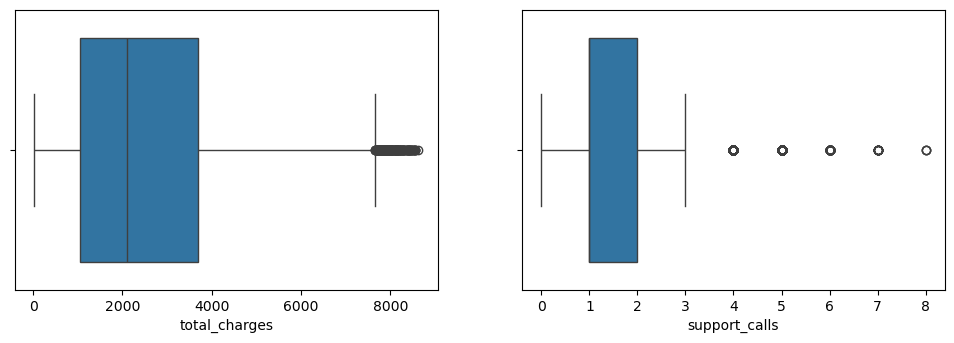

In [11]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
sns.boxplot(data=df_raw, x='total_charges')
plt.subplot(2,2,2)
sns.boxplot(data=df_raw, x='support_calls') 
plt.show()

** Treating Outliers **

In [12]:
treat_columns =['total_charges', 'support_calls']
for column in treat_columns:
    Q1 = df_raw[column].quantile(0.25)
    Q3 = df_raw[column].quantile(0.75)
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    df_raw[column] = np.clip(df_raw[column], lower_bound, upper_bound)

<Axes: xlabel='total_charges'>

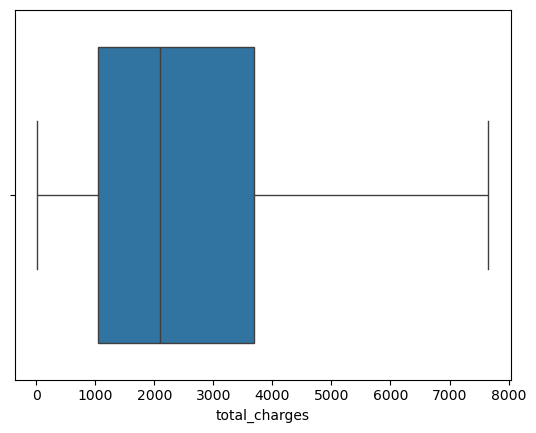

In [13]:
sns.boxplot(x= df_raw['total_charges'])

** Visualization **

<Axes: xlabel='churn'>

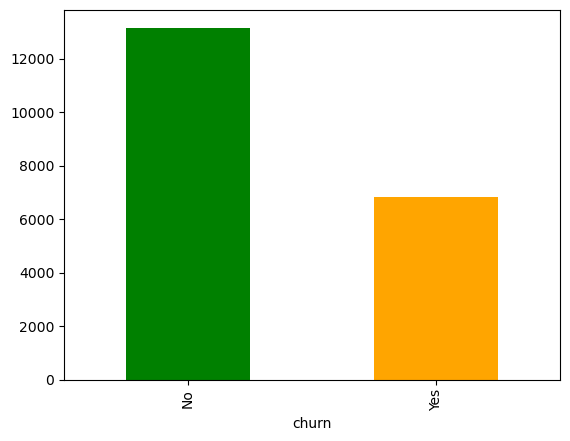

In [14]:
df_raw['churn'].value_counts().plot(kind='bar', color=['green','orange'])

<Axes: xlabel='contract'>

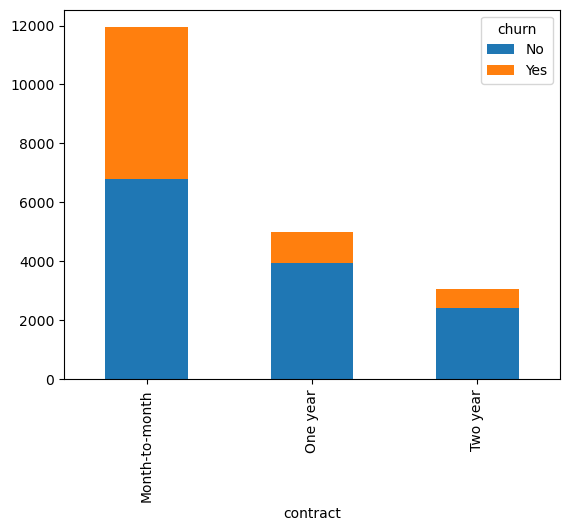

In [15]:
pd.crosstab(df_raw['contract'], df_raw['churn']).plot(kind='bar', stacked=True)

<Axes: xlabel='internet_service', ylabel='monthly_charges'>

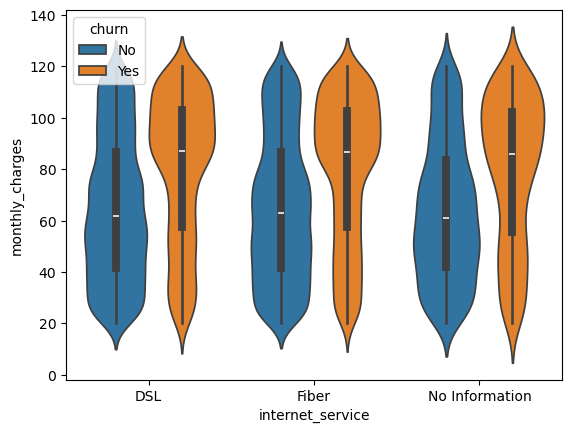

In [16]:
sns.violinplot(x= df_raw['internet_service'], y=df_raw['monthly_charges'], hue = df_raw['churn'])

<Axes: xlabel='support_calls', ylabel='Count'>

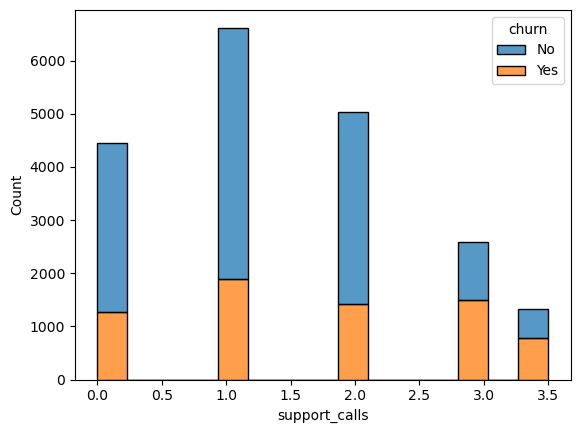

In [17]:
sns.histplot(data=df_raw, x='support_calls', bins=15,hue='churn', multiple='stack')

<Axes: xlabel='tech_support'>

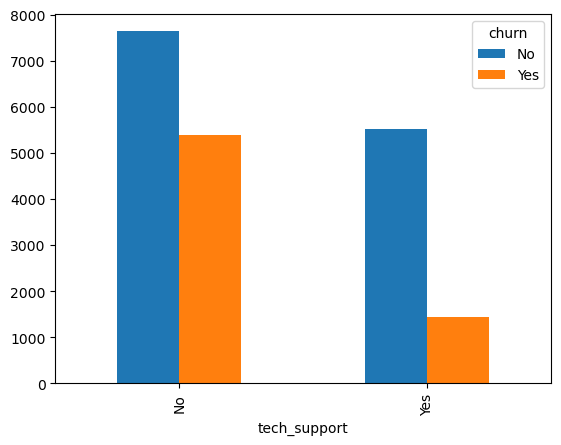

In [18]:
pd.crosstab(df_raw['tech_support'], df_raw['churn']).plot(kind='bar')

<Axes: >

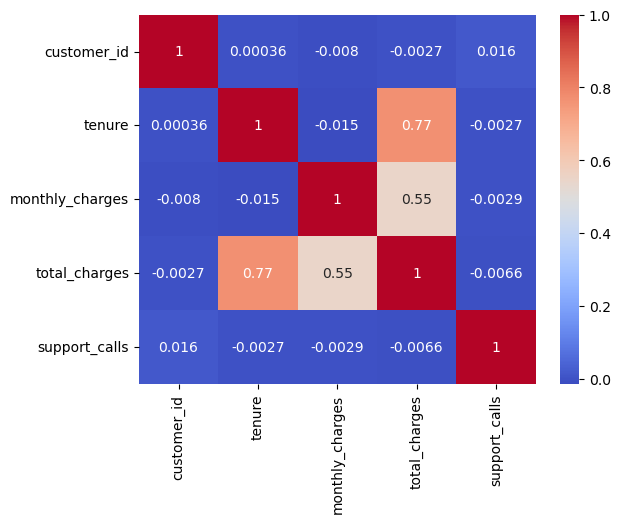

In [19]:
numeric_df = df_raw.select_dtypes(include=[np.number])
corr = numeric_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')

** Hypothesis Testing **

In [20]:
from scipy import stats

In [21]:
# Null Hypothesis: Contract type has no effect on customer churn.
# Alternate Hypothesis: Customers with month-to-month contracts are more likely to churn than those with longer-term contracts.
table = pd.crosstab(df_raw['contract'], df_raw['churn'])
chi2, p_val, dof, expected = stats.chi2_contingency(table)
print(f'Chi-square: {chi2} \nP-value: {p_val}')

Chi-square: 1059.2474824022893 
P-value: 9.712515197996976e-231


In [22]:
# We reject the null hypothesis

In [23]:
# H₀: Monthly charges are not associated with churn.
# H₁: Higher monthly charges = higher churn.

month_churn = df_raw[df_raw['churn'] == 'Yes']['monthly_charges']
month_no_churn = df_raw[df_raw['churn'] == 'No']['monthly_charges']
t_stat, p_val = stats.ttest_ind(month_churn, month_no_churn, equal_var=False)
print(f'T-statistics: {t_stat} \nP-value: {p_val}')

T-statistics: 35.53458422863072 
P-value: 1.2416378913194341e-264


In [24]:
# We reject the null hypothesis

In [25]:
# H₀: Payment method does not influence churn.
# H₁: UPI or cash users churn more.

table = pd.crosstab(df_raw['payment_method'], df_raw['churn'])
chi2, p_val, dof, expected = stats.chi2_contingency(table)
print(f'Chi-square: {chi2} \nP-value: {p_val}')

Chi-square: 0.28623373209724723 
P-value: 0.9625964044826463


In [26]:
# We failed to reject the null hypothesis

In [27]:
# H₀: Mean total charges are equal across payment methods.
# H₁: Mean total charges differ across payment methods.

groups = [df_raw[df_raw['payment_method'] == pm]['total_charges']
         for pm in df_raw['payment_method'].unique()]
f_stat, p_val= stats.f_oneway(*groups)
print(f'F-statistics: {f_stat} \nP-value: {p_val}')

F-statistics: 1.7499446973340953 
P-value: 0.1544278452855657


In [28]:
# We failed to reject the null hypothesis.

In [29]:
# H₀: Neither internet service type nor contract type affects monthly charges.
# H₁: Internet service type, contract type, or their interaction significantly affects monthly charges.

import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('monthly_charges ~ C(internet_service) + C(contract) + C(internet_service):C(contract)', data = df_raw).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                                       sum_sq       df         F    PR(>F)
C(internet_service)              1.197222e+03      2.0  0.717099  0.488179
C(contract)                      4.907078e+01      2.0  0.029392  0.971036
C(internet_service):C(contract)  2.998755e+03      4.0  0.898081  0.464001
Residual                         1.668784e+07  19991.0       NaN       NaN


** Making Predictions **

In [30]:
cat_fields = df_raw.select_dtypes(exclude=[np.number]).columns
cat_fields

Index(['contract', 'payment_method', 'internet_service', 'tech_support',
       'online_security', 'churn'],
      dtype='object')

In [31]:
le = LabelEncoder()
for i in cat_fields:
    df_raw[i] = le.fit_transform(df_raw[i])

In [32]:
# Splitting our data for train and test
x = df_raw.drop(['total_charges','customer_id'], axis=1)
y = df_raw[['total_charges']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=40)

In [33]:
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

In [34]:
lr.coef_

array([[ 69.898787  ,  36.28279134,  12.17425231,  -1.09316376,
        -11.15119601,  19.45665509,  -3.3269567 ,  -5.05866919,
         -0.23755966]])

In [35]:
dict(zip(x_train.columns, lr.coef_[0]))

{'tenure': np.float64(69.89878700363525),
 'monthly_charges': np.float64(36.28279133719957),
 'contract': np.float64(12.174252313282553),
 'payment_method': np.float64(-1.0931637602570128),
 'internet_service': np.float64(-11.15119601031124),
 'tech_support': np.float64(19.456655090320456),
 'online_security': np.float64(-3.3269567009404724),
 'support_calls': np.float64(-5.058669192296541),
 'churn': np.float64(-0.23755966220812835)}

In [36]:
y_pred = lr.predict(x_test)

In [37]:
print(f'R-square value: {r2_score(y_test, y_pred)}')

R-square value: 0.8970592753942779


In [38]:
x_ols = sm.add_constant(x)
ols_model = sm.OLS(y, x_ols).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:          total_charges   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                 1.996e+04
Date:                Thu, 08 Jan 2026   Prob (F-statistic):               0.00
Time:                        16:39:07   Log-Likelihood:            -1.5608e+05
No. Observations:               20000   AIC:                         3.122e+05
Df Residuals:                   19990   BIC:                         3.123e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -2537.1408     17.176  